In [86]:
import numpy as np
import pandas as pd
import os
import time
from tqdm import tqdm, trange
import sys
import matplotlib.pyplot as plt

In [ ]:
# variaveis
L = 100 # lado do lattice
n_lagartos = L**2 # lagartos que cabem no lattice
estrategias = ['O', 'Y', 'B'] # estratégias possíveis
a = 2 # ganho em fitness ao vencer
b = 1/a # ganho em fitness ao perder
matriz_payoff = np.array([[1, b, a],
                          [a, 1, b],
                          [b, a, 1]])
index_map = {'O': 0, 'Y': 1, 'B': 2}
n_geracoes = 100
n_pop = 50 # número de populações independentes
prob_mutacao = None # probabilidade de mutação a cada geração
Y_max = 24 # número máximo de vizinhos de Y no teste de sensibilidade
output_dir = "C:/Unicamp/mestrado/simulacoes/RPS-python/RPS-POO/outputs/sensibilidade/vizinhosY/"
os.makedirs(output_dir, exist_ok=True)

In [88]:
class Lagarto:
  def __init__(self, i, j, estrategia, fitness, coord_vizinhos, estrategia_vizinhos, coord_vizinhanca_extendida, estrategia_vizinhanca_extendida, t, n_vizinhos):
    self.i = i # linha
    self.j = j # coluna
    self.estrategia = estrategia
    self.fitness = 0 # inicia com 0 de fitness
    self.coord_vizinhos = [] # lista vazia para adicionar as coordenadas dos vizinhos
    self.estrategia_vizinhos = [] # lista vazia para adicionar as estratégias dos vizinhos
    self.coord_vizinhanca_extendida = []
    self.estrategia_vizinhanca_extendida = []
    self.t = 0 # determina a geracao do lagarto
    self.n_vizinhos = 0 # número de vizinhos

  def calcular_coord_vizinhos(self, L, n_vizinhos_Y): # obtém as coordenadas dos vizinhos

    lista_vizinhos = []
      
    if self.estrategia == 'B':
        # Von Neumann (4 vizinhos)
        deltas = [(-1,0), (1,0), (0,-1), (0,1)]
        for dx, dy in deltas:
            ni = (self.i + dx) % L
            nj = (self.j + dy) % L
            lista_vizinhos.append((ni, nj))

    elif self.estrategia == 'O':
        # Moore (8 vizinhos)
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                ni = (self.i + dx) % L
                nj = (self.j + dy) % L
                lista_vizinhos.append((ni, nj))

    elif self.estrategia == 'Y':
        # Vizinhos mais próximos (laterais e diagonais), quantidade definida por n_vizinhos_Y
        # Gera todos os vizinhos possíveis (exceto ele mesmo)
        vizinhos_possiveis = []
        for dx in range(-3, 4):
            for dy in range(-3, 4):
                if dx == 0 and dy == 0:
                    continue
                ni = (self.i + dx) % L
                nj = (self.j + dy) % L
                vizinhos_possiveis.append(((ni, nj), max(abs(dx), abs(dy))))
        # Ordena por distância (mais próximos primeiro)
        vizinhos_possiveis.sort(key=lambda x: x[1])
        # Seleciona os n_vizinhos_Y mais próximos
        lista_vizinhos = [coord for coord, _ in vizinhos_possiveis[:n_vizinhos_Y]]

    self.coord_vizinhos = lista_vizinhos
    
  def obter_estrategia_vizinhos(self, matriz_posicao):
      self.estrategia_vizinhos = [matriz_posicao[ni, nj] for ni, nj in self.coord_vizinhos] # dadas as coordenadas, obtém a estratégia do lagarto que ocupa aquela posição

  def mutacao(self, prob_mutacao): # função de mutação
    if np.random.rand() < prob_mutacao: # sorteia um valor entre 0 e 1, se for menor que a probabilidade de mutação, o lagarto muda de estratégia
        estrategias_possiveis = [e for e in estrategias if e != self.estrategia] # obtém as estratégias possíveis, exceto a atual
        self.estrategia = np.random.choice(estrategias_possiveis) # escolhe uma nova estratégia aleatoriamente para mutar

  def calcular_n_vizinhos(self): # calcula o número de vizinhos
      self.n_vizinhos = len(self.estrategia_vizinhos) + len(self.estrategia_vizinhanca_extendida)

def calcular_media_vizinhos(lagartos, estrategias):
    medias = []
    for e in estrategias:
        viz = [lag.n_vizinhos for lag in lagartos if lag.estrategia == e]
        medias.append(np.mean(viz) if len(viz) > 0 else 0)
    return medias # retorna a média de vizinhos para cada estratégia

def ajustar_vizinhos_reciprocos(lagartos): # garante que se A é vizinho de B, B também é vizinho de A, pois as interações são recíprocas
    mapa = {(l.i, l.j): l for l in lagartos} # dicionário pra acessar lagartos pela posição

    for l in lagartos:
        for (ni, nj) in l.coord_vizinhos: # vai em todos os vizinhos do lagarto atual (l)
            vizinho = mapa[(ni, nj)]
            # se o lagarto atual (l) não estiver na lista de vizinhos do vizinho, adiciona em vizinhanca_extendida
            if (l.i, l.j) not in vizinho.coord_vizinhos:
                vizinho.estrategia_vizinhanca_extendida.append(str(l.estrategia))
                vizinho.coord_vizinhanca_extendida.append((l.i, l.j))

In [89]:
def criar_lagartos(n_lagartos, L, estrategias): # define as posições e estratégias dos lagartos no t = 0
  lista_lagartos = []

  # posições iniciais aleatórias
  all_positions = [(i, j) for i in range(L) for j in range(L)] # forma todas as posições possíveis em um lattice
  unique_positions_indices = np.random.choice(len(all_positions), n_lagartos, replace=False) # determina o índice de onde vai ficar cada posição
  unique_positions = [all_positions[i] for i in unique_positions_indices] # basicamente, ele embaralhou as posições

  for g in range(n_lagartos):
    i, j = unique_positions[g] # posição na matriz
    estrategia = np.random.choice(estrategias) # sorteia a estrategia
    lista_lagartos.append(Lagarto(i, j, estrategia, 0, [], [], [], [], 0, 0)) # cria o lagarto
  return lista_lagartos

def calcular_fitness(lagarto, matriz_payoff, index_map, matriz_posicao): # função para calcular o fitness do lagarto
    fitness_total = 0 # inicia no 0
    
    todos_vizinhos = set(lagarto.coord_vizinhos + lagarto.coord_vizinhanca_extendida) # junta todos os vizinhos (normais e estendidos) em um set para evitar que um vizinho seja contado duas vezes
    for ni, nj in todos_vizinhos:
        vizinho_estrat = matriz_posicao[ni, nj] # pega a estratégia do vizinho dadas as suas coordenadas
        if vizinho_estrat is not None:
            fitness_total += matriz_payoff[index_map[lagarto.estrategia], index_map[vizinho_estrat]] # calcula o payoff do lagarto contra o vizinho de acordo com a matriz de payoff e soma ao fitness total
    lagarto.fitness = fitness_total
    return fitness_total

calcular_freq = lambda mat: np.array([np.sum(mat == s) / (L ** 2) for s in ['O', 'Y', 'B']]) # calcula a frequência de cada estratégia no lattice na ordem O, Y, B

In [90]:
def atualizar_lagartos(lagartos): # função que atualiza as estratégias dos lagartos com base no fitness dos vizinhos
    novas_estrategias = {} # Dicionário para armazenar as novas estratégias

    mapa = {(l.i, l.j): l for l in lagartos} # dicionário para acessar lagartos pela posição

    for lagarto in lagartos:
        melhor_estrategia = lagarto.estrategia # inicia com a própria estratégia
        maior_fitness = lagarto.fitness # verifica o fitness do próprio lagarto

        # verifica o fitness dos vizinhos normais
        for (ni, nj) in lagarto.coord_vizinhos:
            vizinho = mapa[(ni, nj)] # usa o dicionário para achar o vizinho
            if vizinho.fitness > maior_fitness: # se o fitness do vizinho for maior que o maior fitness atual
                maior_fitness = vizinho.fitness # atualiza o maior fitness
                melhor_estrategia = vizinho.estrategia # atualiza a melhor estratégia
                # se houver empate de fitness ou for menor, mantém a estratégia atual (não muda)

        # verifica o fitness dos vizinhos extendidos
        for (ni, nj) in lagarto.coord_vizinhanca_extendida:
            vizinho = mapa[(ni, nj)] 
            if vizinho.fitness > maior_fitness:
                maior_fitness = vizinho.fitness
                melhor_estrategia = vizinho.estrategia

        novas_estrategias[(lagarto.i, lagarto.j)] = melhor_estrategia # armazena a nova estratégia no dicionário

    # atualiza as estratégias de todos os lagartos simultaneamente
    for lagarto in lagartos:
        lagarto.estrategia = novas_estrategias[(lagarto.i, lagarto.j)] # evita que a atualização de um lagarto influencie outro na mesma geração (sem sobreposição de geração)

    
    return lagartos

In [ ]:
# iniciando a simulação
def simulacao(n_geracoes, L, n_lagartos, estrategias, matriz_payoff, index_map, n_pop, Y_max, prob_mutacao = None, seed = None):
    matriz_frequencias = np.full((n_geracoes + 1, n_pop, Y_max, len(estrategias)), None) # cria uma matriz em que as linhas são as gerações, e as colunas são as populações
    # armazena as frequências das três estratégias
    matriz_n_vizinhos = np.full((n_geracoes + 1, n_pop, Y_max, len(estrategias)), np.nan, dtype=float) # cria uma matriz para armazenar vizinhos

    for y in range(1, Y_max+1): # loop para cada valor de vizinhos de Y
    
      for pop in tqdm(range(n_pop), desc="Simulações"): # loop para cada população independente
        if seed is not None:
            np.random.seed(seed + pop) # coloca uma semente diferente pra cada pop, garantindo independência

        frequencias = [] # vai armazenar as frequências ao longo das gerações para essa população
        lista_lagartos = criar_lagartos(n_lagartos, L, estrategias) # cria os lagartos
        matriz_posicao = np.full((L, L), None) # cria uma matriz vazia com None
        for lagarto in lista_lagartos:
          matriz_posicao[lagarto.i, lagarto.j] = str(lagarto.estrategia) # cria a matriz de posições de acordo com os lagartos

        frequencias.append(calcular_freq(matriz_posicao)) # calcula a frequência inicial

        for t in trange(1, n_geracoes + 1, desc="Gerações", leave=False): # loop para cada geração dentro da população
          # determinando os vizinhos
          for lagarto in lista_lagartos:
            lagarto.calcular_coord_vizinhos(L, n_vizinhos_Y = y) # calcula as coordenadas dos vizinhos
            # Y assume o número de vizinhos igual a y (de 1 até o máximo determinado)
            lagarto.obter_estrategia_vizinhos(matriz_posicao) # obtém as estratégias dos vizinhos

            lagarto.coord_vizinhanca_extendida = [] # zera a vizinhança estendida para recalcular
            lagarto.estrategia_vizinhanca_extendida = [] 

          ajustar_vizinhos_reciprocos(lista_lagartos) # ajusta as vizinhanças recíprocas

          for lagarto in lista_lagartos:
            lagarto.calcular_n_vizinhos() # calcula o número de vizinhos
        
          matriz_n_vizinhos[t, pop, y-1, :] = calcular_media_vizinhos(lista_lagartos, estrategias) # # calcula a média de vizinhos para cada estratégia e armazena na matriz de vizinhos
          #print(matriz_n_vizinhos[t, pop, y-1, :]) # debug

          # calculando o fitness
          for lagarto in lista_lagartos:
            calcular_fitness(lagarto, matriz_payoff, index_map, matriz_posicao) # calcula o fitness do lagarto de acordo com seus vizinhos e a matriz de fitness

          # criando a matriz de fitness
          matriz_fitness = np.full((L, L), None) # cria uma matriz vazia com None
          for lagarto in lista_lagartos:
            matriz_fitness[lagarto.i, lagarto.j] = float(lagarto.fitness) # coloca os fitness nas posições

          lista_lagartos = atualizar_lagartos(lista_lagartos) # atualiza as estratégias dos lagartos de acordo com o maior fitness dos vizinhos

          if prob_mutacao is not None:
            for lagarto in lista_lagartos:
              lagarto.mutacao(prob_mutacao) # aplica a mutação

          # atualiza a matriz de posição com as novas estratégias e com as mutações
          matriz_posicao = np.full((L, L), None)
          for lagarto in lista_lagartos:
            matriz_posicao[lagarto.i, lagarto.j] = str(lagarto.estrategia)

          frequencias.append(calcular_freq(matriz_posicao)) # calcula a frequência dessa geração e armazena em frequencias

          for lagarto in lista_lagartos:
              lagarto.t += 1 # incrementa a geração do lagarto

        frequencias = np.array(frequencias)
        matriz_frequencias[:, pop, y-1, :] = frequencias
    
      # Salvar médias por geração e estratégia para cada y
      linhas_freq = []
      linhas_viz = []
      for t in range(n_geracoes + 1):
          for idx, strategy in enumerate(estrategias):
              # Média de frequência sobre as populações
              freq_media = np.mean(matriz_frequencias[t, :, y-1, idx])
              # Média de vizinhos sobre as populações
              viz_media = np.mean(matriz_n_vizinhos[t, :, y-1, idx])
              linhas_freq.append({
                  "t": t,
                  "y": y,
                  "estrategia": strategy,
                  "frequencia_media": freq_media
              })
              linhas_viz.append({
                  "t": t,
                  "y": y,
                  "estrategia": strategy,
                  "n_vizinhos_media": viz_media
              })
      # Salva CSV para cada y
      df_freq_y = pd.DataFrame(linhas_freq)
      df_freq_y.to_csv(os.path.join(output_dir, f"frequencias_sensibilidadeY_y{y}.csv"), index=False)
      df_viz_y = pd.DataFrame(linhas_viz)
      df_viz_y.to_csv(os.path.join(output_dir, f"n_vizinhos_y{y}.csv"), index=False)


    return matriz_frequencias, matriz_n_vizinhos

freq, n_vizinhos = simulacao(n_geracoes, L, n_lagartos, estrategias, matriz_payoff, index_map, n_pop, Y_max, prob_mutacao, seed = 1)

Simulações: 100%|██████████| 50/50 [28:42<00:00, 34.45s/it]


In [56]:
linhas = []
t_final = freq.shape[0] - 1  # última geração
for pop in range(freq.shape[1]):       # populações
    for y in range(freq.shape[2]):     # valores de y (n_vizinhos_Y)
        for idx, strategy in enumerate(estrategias):  # estratégias
            linhas.append({
                "t": t_final,                # geração final
                "pop": pop,                  # população
                "y": y,                      # número de vizinhos de Y
                "estrategia": strategy,
                "frequencia": freq[t_final, pop, y, idx]
            })

df_long = pd.DataFrame(linhas)
df_long.to_csv(os.path.join(output_dir, "frequencias_sensibilidadeY_final.csv"), index=False)

In [57]:
# salva a matriz de vizinhos como DataFrame formato tidy
linhas = []
n_vizinhos = np.array(n_vizinhos, dtype=float)

for t in range(n_vizinhos.shape[0]):          # gerações
    for pop in range(n_vizinhos.shape[1]):    # populações
        for y in range(n_vizinhos.shape[2]):        # valores de y (n_vizinhos_Y)
            for idx, strategy in enumerate(estrategias):  # estratégias
                linhas.append({
                    "t": t,                        # geração
                    "pop": pop,                    # população
                    "y": y,                        # número de vizinhos de Y
                    "estrategia": strategy,        # estratégia
                    "n_vizinhos": n_vizinhos[t, pop, y, idx]  # média de vizinhos
                })

df_n_vizinhos = pd.DataFrame(linhas)

# salvar como CSV
df_n_vizinhos.to_csv(os.path.join(output_dir, f"n_vizinhos.csv"), index=False)

print(df_n_vizinhos.head(10))

   t  pop  y estrategia  n_vizinhos
0  0    0  0          O         NaN
1  0    0  0          Y         NaN
2  0    0  0          B         NaN
3  0    0  1          O         NaN
4  0    0  1          Y         NaN
5  0    0  1          B         NaN
6  0    0  2          O         NaN
7  0    0  2          Y         NaN
8  0    0  2          B         NaN
9  0    0  3          O         NaN


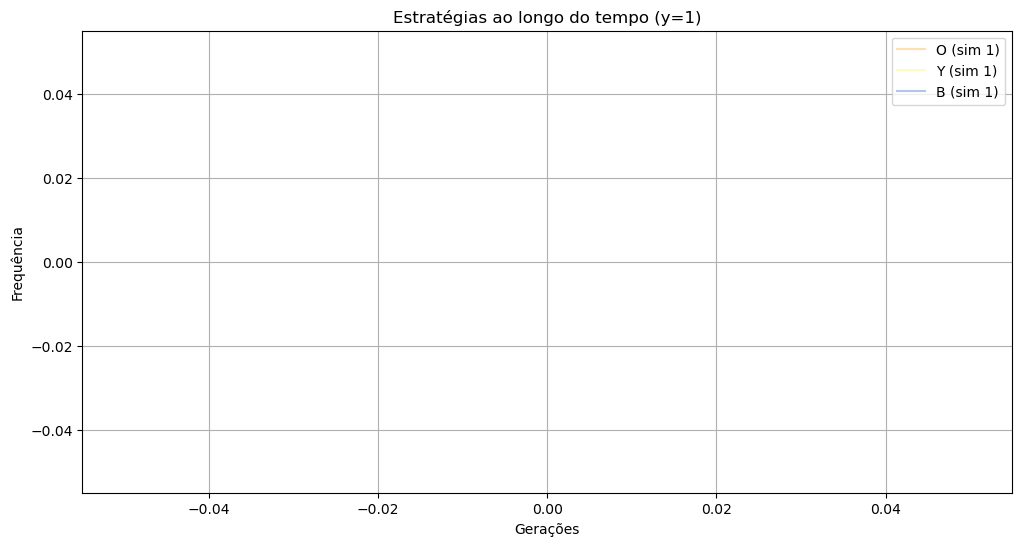

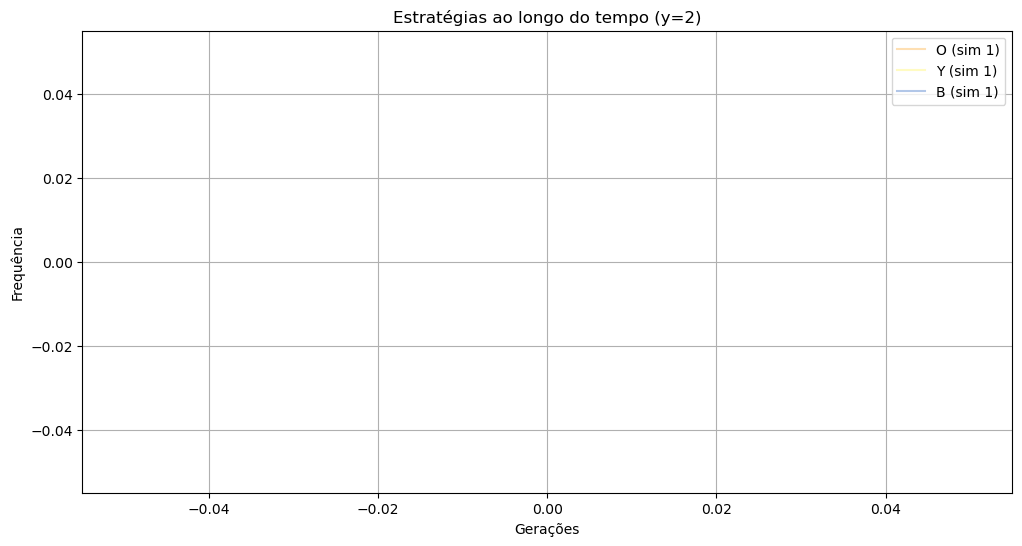

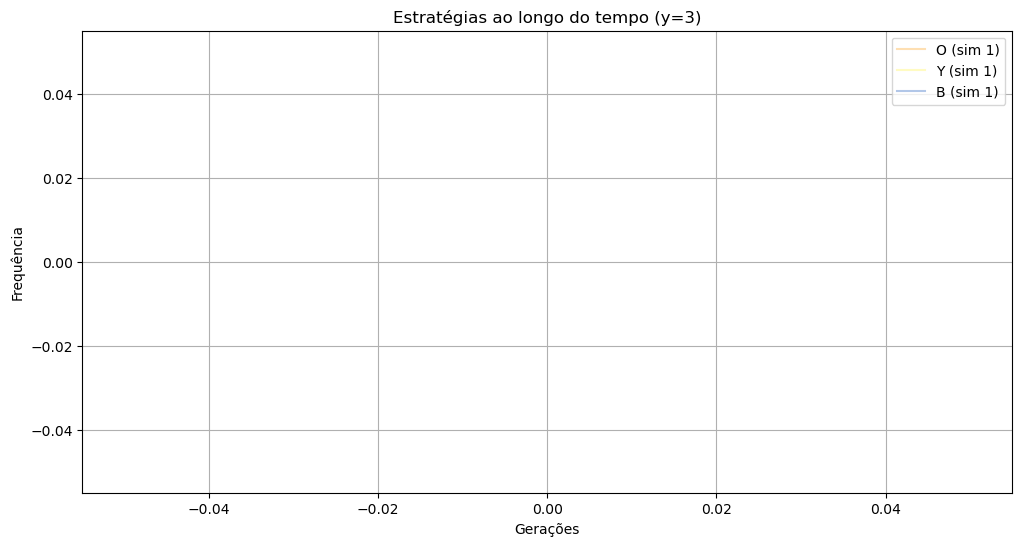

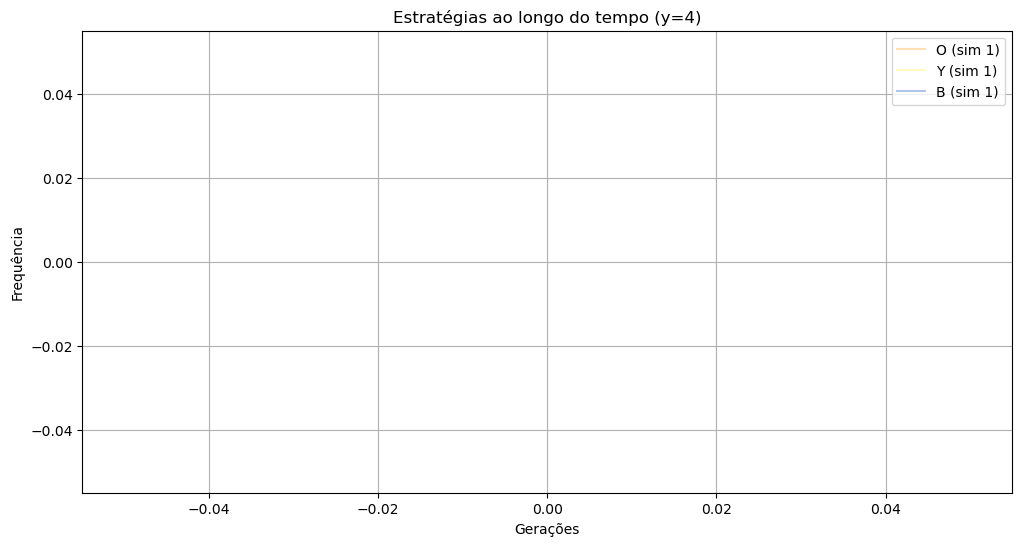

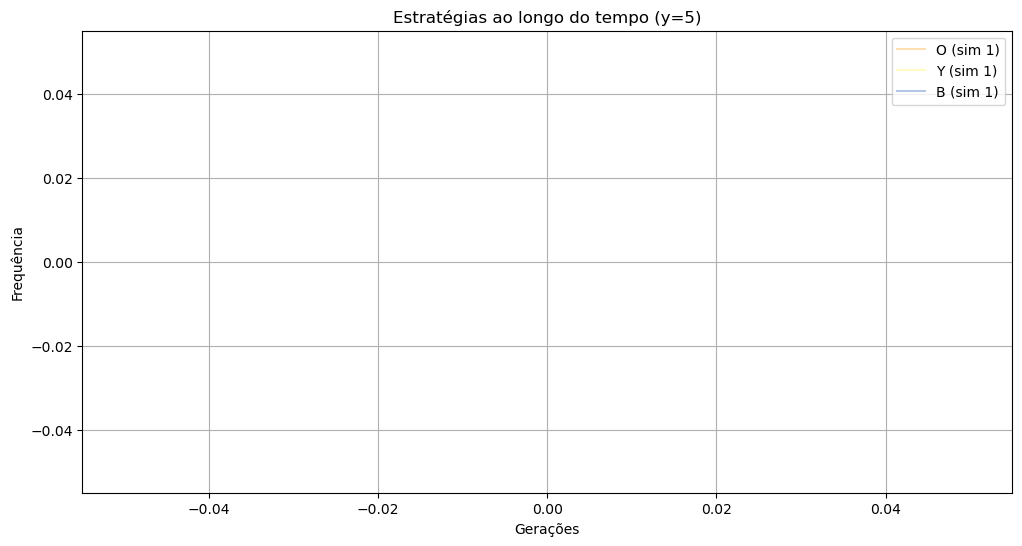

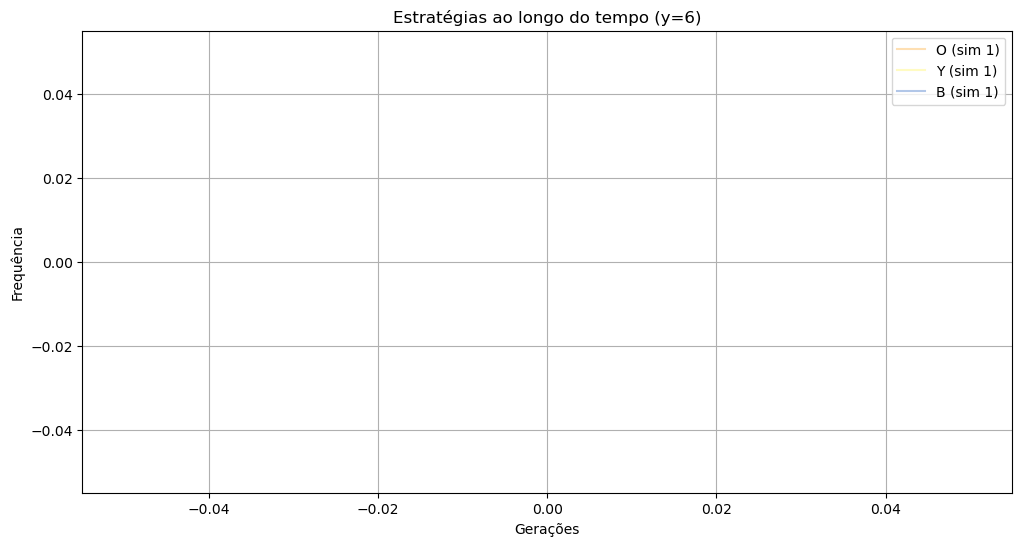

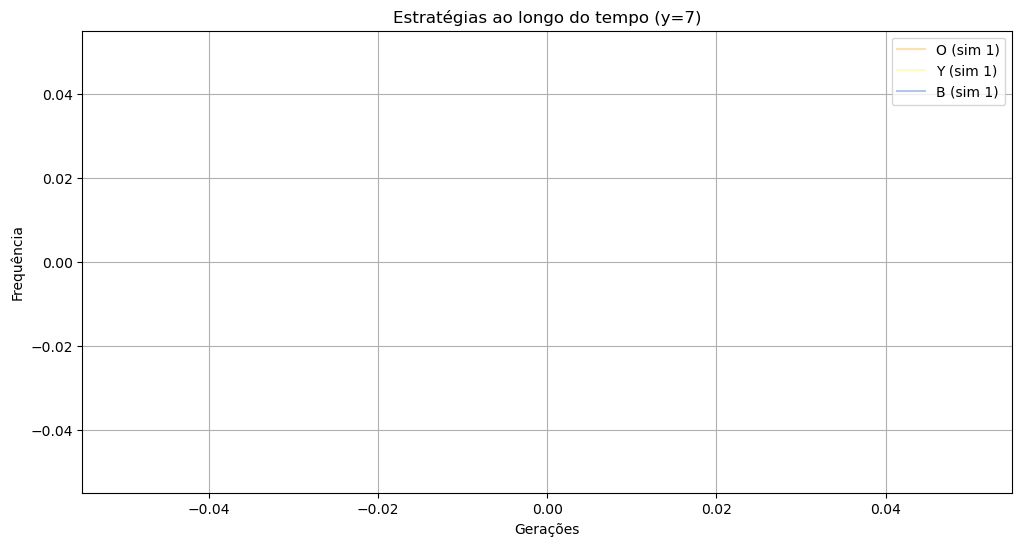

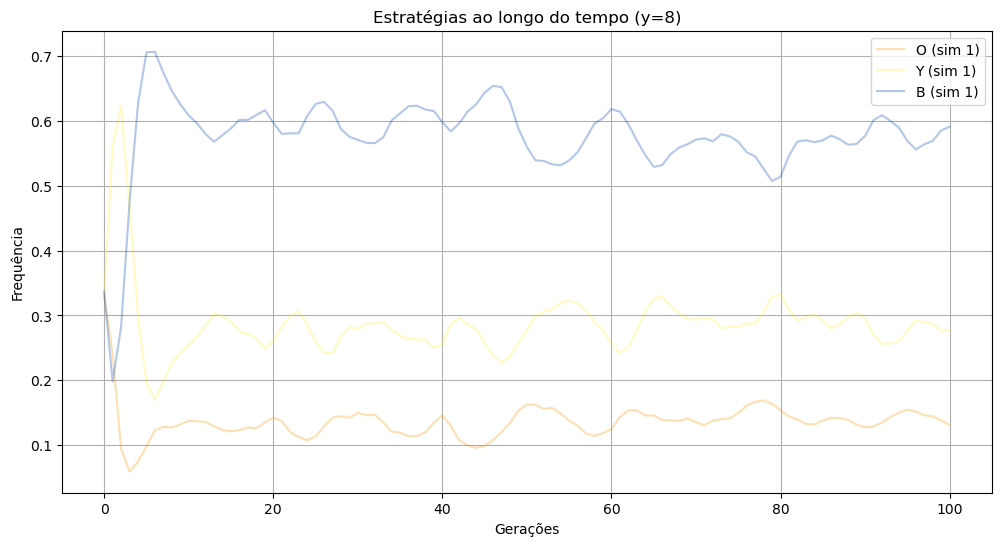

In [58]:
cores = {"O": "#FD9800", "B": "#0047B3", "Y": "#FFF237"}

t_max = freq.shape[0]
n_pop = freq.shape[1]
Y_max = freq.shape[2]

for y in range(1, Y_max):  # começa em 1 para ignorar y=0
    plt.figure(figsize=(12, 6))
    for pop in range(n_pop):
        for idx, strategy in enumerate(estrategias):
            plt.plot(
                range(t_max),
                freq[:, pop, y, idx],
                label=f"{strategy} (sim {pop+1})" if pop == 0 else None,
                color=cores[strategy],
                alpha=0.3
            )
    plt.title(f"Estratégias ao longo do tempo (y={y})")
    plt.xlabel("Gerações")
    plt.ylabel("Frequência")
    plt.grid(True)
    plt.legend()
    plt.show()

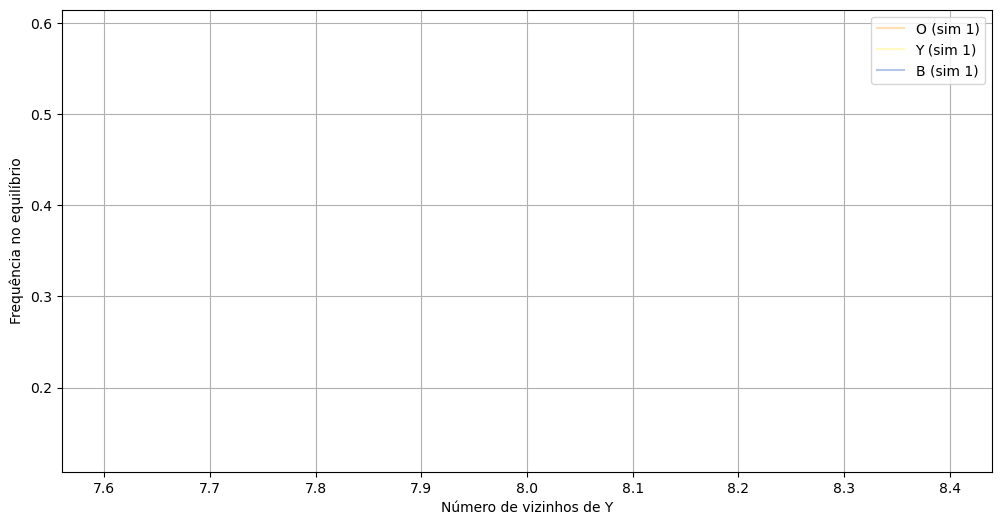

In [59]:
cores = {"O": "#FD9800", "B": "#0047B3", "Y": "#FFF237"}

plt.figure(figsize=(12, 6))

t_final = freq.shape[0] - 1  # última geração

for pop in range(freq.shape[1]):  # para cada simulação
    for idx, strategy in enumerate(estrategias):
        plt.plot(
            range(1, freq.shape[2]),  # eixo x: número de vizinhos de Y (de 1 até Y_max)
            freq[t_final, pop, 1:, idx],  # ignora y=0, pega só de y=1 até Y_max
            label=f"{strategy} (sim {pop+1})" if pop == 0 else None,
            color=cores[strategy],
            alpha=0.3
        )

plt.xlabel("Número de vizinhos de Y")
plt.ylabel("Frequência no equilíbrio")
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(output_dir, "plot_freq_final_vs_vizinhosY.png"), dpi=300, bbox_inches='tight')
plt.show()

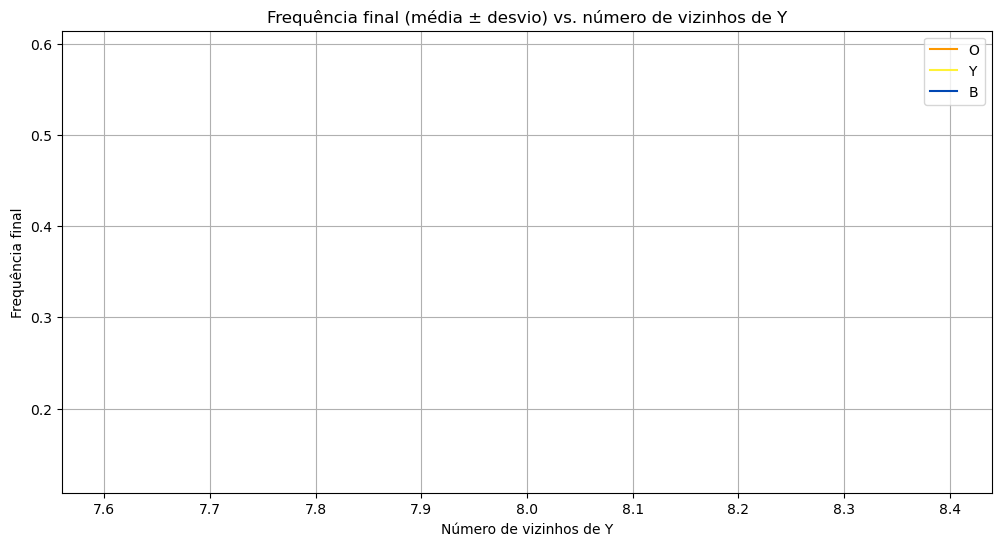

In [60]:
cores = {"O": "#FD9800", "B": "#0047B3", "Y": "#FFF237"}

plt.figure(figsize=(12, 6))

t_final = freq.shape[0] - 1  # última geração

for idx, strategy in enumerate(estrategias):
    media = np.array(freq[t_final, :, 1:, idx], dtype=float).mean(axis=0)   # média sobre as populações
    desvio = np.array(freq[t_final, :, 1:, idx], dtype=float).std(axis=0)   # desvio padrão sobre as populações

    plt.plot(range(1, freq.shape[2]), media, label=strategy, color=cores[strategy])
    plt.fill_between(range(1, freq.shape[2]), media-desvio, media+desvio, color=cores[strategy], alpha=0.2)

plt.title("Frequência final (média ± desvio) vs. número de vizinhos de Y")
plt.xlabel("Número de vizinhos de Y")
plt.ylabel("Frequência final")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "plot_freq_final_media_vs_vizinhosY.png"), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

Y_max = 24
estrategias = ['O', 'Y', 'B']
cores = {"O": "#FD9800", "B": "#0047B3", "Y": "#FFF237"}

valores_medias = {estrat: [] for estrat in estrategias}

for y in range(1, Y_max+1):
    df = pd.read_csv(os.path.join(output_dir, f"n_vizinhos_y{y}.csv"))
    for estrat in estrategias:
        media = df[df['estrategia'] == estrat]['n_vizinhos_media'].mean()
        valores_medias[estrat].append(media)

plt.figure(figsize=(10, 6))
for estrat in estrategias:
    plt.plot(range(1, Y_max+1), valores_medias[estrat], label=estrat, color=cores[estrat])

plt.xlabel("Número de vizinhos de Y (y)")
plt.ylabel("Média de vizinhos por estratégia (média das gerações)")
plt.title("Média de vizinhos por estratégia (média das gerações) vs. y")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "plot_n_vizinhos_vs_vizinhosY.png"), dpi=300, bbox_inches='tight')
plt.show()

# Dicionário para guardar os valores finais por estratégia
valores_finais = {estrat: [] for estrat in estrategias}

for y in range(1, Y_max+1):
    df = pd.read_csv(os.path.join(output_dir, f"n_vizinhos_y{y}.csv"))
    t_final = df['t'].max()
    for estrat in estrategias:
        valor = df[(df['t'] == t_final) & (df['estrategia'] == estrat)]['n_vizinhos_media'].mean()
        valores_finais[estrat].append(valor)

plt.figure(figsize=(10, 6))
for estrat in estrategias:
    plt.plot(range(1, Y_max+1), valores_finais[estrat], label=estrat, color=cores[estrat])

plt.xlabel("Número de vizinhos de Y (y)")
plt.ylabel("Média de vizinhos por estratégia (última geração)")  
plt.title("Média de vizinhos por estratégia na última geração vs. y")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(output_dir, "plot_n_vizinhos_final_vs_vizinhosY.png"), dpi=300, bbox_inches='tight')
plt.show()